Summary of Steps:

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with
cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
PATH = "d:/standing/"

In [3]:
import simple_binary_image_classifier as bc

In [6]:
model1000 = bc.BinaryClassifier(PATH)

Use lr_find() to find highest learning rate where loss is still clearly improving

In [7]:
model1000.learning_rate_finder()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|█████████████████████████████████████████████████████▎                 | 45/60 [00:01<00:00, 30.20it/s, loss=3.66]


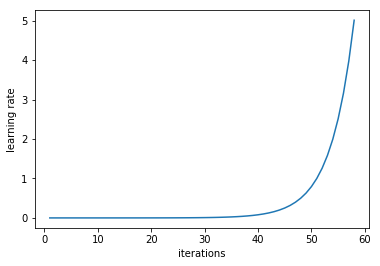

In [8]:
model1000.plot_learning_rate()

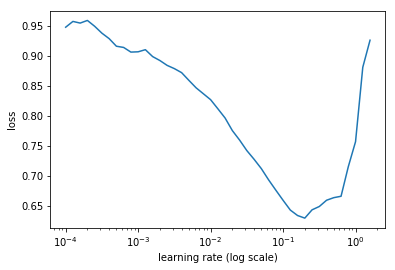

In [9]:
model1000.plot_learning_rate_schedule()

In [10]:
lr = 0.01

Train last layer from precomputed activations for 1-2 epochs

In [11]:
model1000.fit(lr)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.331437   0.131978   0.975302  
    1      0.222435   0.113371   0.963998                                                                              



Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with
cycle_len=1

In [12]:
model1000.set_precompute(False)

In [13]:
model1000.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.261628   0.125901   0.959677  
    1      0.254672   0.146906   0.944052                                                                              
    2      0.2486     0.150459   0.9393                                                                                



Unfreeze all layers

In [14]:
model1000.learn.unfreeze()

Set earlier layers to 3x-10x lower learning rate than next higher layer

In [19]:
lr = bc.np.array([1e-3,3e-3,1e-2])

Use lr_find() again

In [16]:
model1000.learning_rate_finder()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|███████████████████████████████████████████████████████████▏           | 50/60 [01:54<00:22,  2.28s/it, loss=1.05]

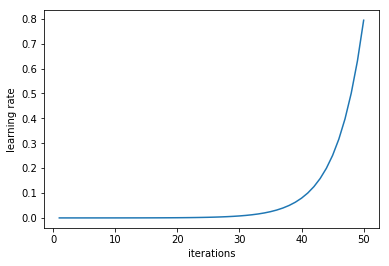

In [17]:
model1000.plot_learning_rate()

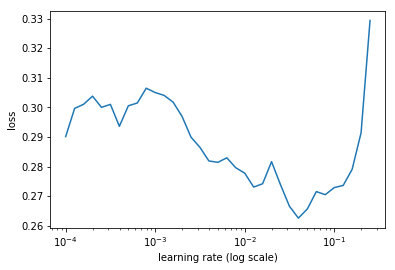

In [18]:
model1000.plot_learning_rate_schedule()

Train full network with cycle_mult=2 until over-fitting

In [20]:
model1000.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|                                                                                           | 0/60 [00:00<?, ?it/s]


Exception in thread Thread-17:
Traceback (most recent call last):
  File "D:\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "D:\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "D:\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.202816   0.090191   0.973214  
    1      0.173527   0.091401   0.977679                                                                              
    2      0.135412   0.093748   0.970982                                                                              
    3      0.109259   0.063005   0.982143                                                                              
    4      0.094794   0.052782   0.979911                                                                              
    5      0.092195   0.066181   0.982143                                                                              
    6      0.076563   0.072204   0.979911                                                                              



In [21]:
model1000.learn.save("model1000")


In [55]:
#http://forums.fast.ai/t/how-do-we-use-our-model-against-a-specific-image/7661/3
trn_tfms, val_tfms = model1000.tfms

In [84]:
single_file = "j:/Om5Eri1.jpg"

In [85]:
im = val_tfms(bc.open_image(single_file))

In [86]:
log_preds = model1000.learn.predict_array(im[None])

In [87]:
preds = bc.np.exp(log_preds)

In [88]:
preds

array([[0.99985, 0.00015]], dtype=float32)